# Learning Auctions with Interdependent Values and Context

In the [previous tutorial](learning-auctions-intro.ipynb), we looked at learning optimal auctions with independent valuations.  In this tutorial, we will consider auctions with interdependent values and context.  The latter is represented by a common component of the values.

## Motivating example

Consider a two-bidder single-item auction where the values for the two bidders are correlated.  There is a signal $c\sim U[0,1]$.  The value of the item for bidder 1 is a random variable $v_1 = x_1 c$ where $x_1 \sim U[0,1]$, similarly for bidder 2 the value $v_2 = x_2 c$ where $x_2 \sim U[0,1]$.

## Architectures and supporting functions

As in the previous tutorial, we will make use of ShadeNet.

### Preliminaries

We will make heavy use of numpy, pandas, and pytorch.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

We will also make use of matplotlib and seaborn for visualization:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Common components

All mechanism networks will output allocations and payments.  The allocation shape is `[batch_size, bidders+1]`.  The first column represents the probability that the item is not allocated, with all other columns representing the probability that the item is allocated to the respective bidder.  The payment shape is `[batch_size, bidders]`.  Here each column represents the payment of the respective bidder.

We define a generic mechanism as follows:

In [3]:
class MechanismNet(nn.Module):
    def __init__(self, allocation_rule, payment_rule):
        super(MechanismNet, self).__init__()
        self.allocation_rule = allocation_rule
        self.payment_rule = payment_rule
        
    def forward(self, x):
        allocation = self.allocation_rule(x)
        return allocation, allocation[:,1:] * self.payment_rule(x)

Utility can thusly be calculated by:

In [4]:
def calc_utility(bids, mechanism, valuation=None, output_components=False):
    valuation = valuation if valuation is not None else bids
    allocation, payment = mechanism(bids)
    if output_components:
        return allocation[:,1:]*valuation-payment, allocation, payment
    else:
        return allocation[:,1:]*valuation-payment

The `calc_utility` function will return a tensor of shape `[batch_size,bidders]`.

In order to determine if a mechanism is (approximately) DSIC, we calculate regret:

In [5]:
def calc_regret(values, mechanism, responders, leaky=False):
    u_true, a_true, p_true = calc_utility(values, mechanism, output_components=True)
    regret = torch.zeros(values.shape).to(device)
    for bidder, responder in enumerate(responders):
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,bidder] = 1.0
        response = responder(values, a_true, p_true)
        u_response = calc_utility(response, mechanism, values)
        if leaky:
            regret = regret + F.leaky_relu((u_response - u_true) * bidder_mask)
        else:
            regret = regret + F.relu((u_response - u_true) * bidder_mask)
    return regret.mean(dim=0)

Finally, we can define the training function.

In [6]:
import torch.optim as optim
import torch.utils.data as data_utils
from tqdm import tqdm

def train(mechanism, responders, values_loader, epochs=1, rho=100, clipping_norm=None):
    # Initialize augmented lagrangian parameters
    lambda_dsic = torch.zeros(bidders).to(device)
    lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-4)
    responder_optimizers = [optim.Adam(r.parameters(), lr=1e-4) for r in responders]
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_loader):
            values = values_list[0].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                values, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = calc_regret(
                values, 
                mechanism,
                responders)
    
            # compute individual rationality violation
            ir_violation = F.relu(-utility).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue\
                +(lambda_dsic*dsic_violation).sum()\
                +(lambda_ir*ir_violation).sum()\
                +0.5*rho*(total_dsic_violation.pow(2)+total_ir_violation.pow(2))
    
            # Trigger the autogradient calculation
            loss.backward()
        
            # Take a step towards the gradient
            mechanism_optimizer.step()
            
            with torch.no_grad():
                mechanism.eval()
                for responder in responders:
                    responder.eval()
                    
                # Update the augmented lagrangian parameters
                dsic_violation_next = calc_regret(
                    values,
                    mechanism,
                    responders)
                u_next = calc_utility(values, mechanism)
                ir_violation_next = F.relu(-u_next).mean(dim=0)
                lambda_dsic = lambda_dsic + rho * dsic_violation_next
                lambda_ir = lambda_ir + rho * ir_violation_next
                mechanism.train()
                for responder in responders:
                    responder.train()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item(),
                'loss':loss.item()})
            
            for bidder, responder in enumerate(responders):
                optimizer = responder_optimizers[bidder]
                optimizer.zero_grad()
                regret = calc_regret(
                    values, 
                    mechanism,
                    responders,
                    leaky=True)
                (-regret[bidder]).backward()
                optimizer.step()
            
    return pd.DataFrame(report_data)     

## Responder

The responder network computes the best response to the mechanism.

In [7]:
class Responder(nn.Module):
    def __init__(self, bidder, hidden_units):
        super(Responder, self).__init__()
        self.bidder = bidder
        self.initial_layer = nn.Linear(2, hidden_units)
        self.hidden_layer = nn.Linear(hidden_units, hidden_units)
        self.final_layer = nn.Linear(hidden_units, 1)
        
    def forward(self, values, allocation, payment):
        x = torch.cat((allocation[:,self.bidder+1].unsqueeze(1), payment[:,self.bidder].unsqueeze(1)), dim=1)
        x = F.leaky_relu(self.initial_layer(x))
        x = F.leaky_relu(self.hidden_layer(x))
        x = torch.sigmoid(self.final_layer(x))
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,self.bidder] = 1.0
        return (1-bidder_mask)*values + bidder_mask * values * x

## RegretNet

The allocation network is defined as follows:

In [8]:
class RegretNetAllocation(nn.Module):
    def __init__(self, bidders, hidden_layers, hidden_units):
        super(RegretNetAllocation, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders+1))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x):
        for layer in self.fc_layers[:-1]:
            x = F.leaky_relu(layer(x))
        return F.softmax(self.fc_layers[-1](x), dim=1)

The payment network is defined as follows:

In [9]:
class RegretNetPayment(nn.Module):
    def __init__(self, bidders, hidden_layers, hidden_units):
        super(RegretNetPayment, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x):
        for layer in self.fc_layers:
            x = F.leaky_relu(layer(x))
        return x

Finally, we can define the RegretNet mechanism:

In [10]:
def create_regret_net(bidders, hidden_layers=2, hidden_units=100):
    return MechanismNet(
        RegretNetAllocation(bidders, hidden_layers, hidden_units),
        RegretNetPayment(bidders, hidden_layers, hidden_units))

## Auction for the motivating example



In [11]:
bidders = 2

The networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [12]:
sample_size = 2**11
batch_size = 2**8

indepedent_components = torch.rand(sample_size, bidders)
common_components = torch.rand(sample_size, 1)
values = indepedent_components * common_components

values_loader=data_utils.DataLoader(
    data_utils.TensorDataset(values),
    batch_size=batch_size)

We now create a simple RegretNet instance with corresponding responders.

In [13]:
regret_net = create_regret_net(bidders).to(device)
regret_net_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]

We loop over the data for a number of epochs and record traces of the networks learning.

In [14]:
epochs = 1000
regret_net_report = train(regret_net, regret_net_responders, values_loader, epochs=epochs)

100%|██████████| 1000/1000 [05:46<00:00,  2.05it/s]


Next, let's review the DSIC violations of the network. In the figure below, we can see that RegretNet has a small and decreasing violation.

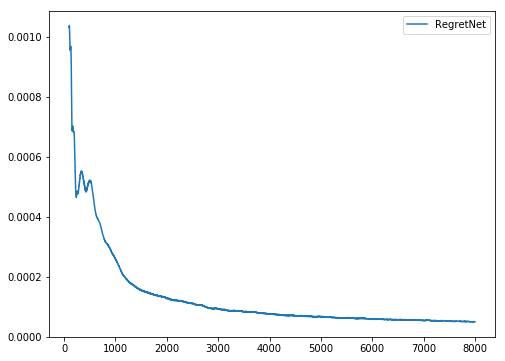

In [15]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(regret_net_report[['total_dsic_violation']].rolling(100).mean(), label='RegretNet');
ax.legend();

Let's review the revenue of the network.  We see that RegretNet increases smoothly.

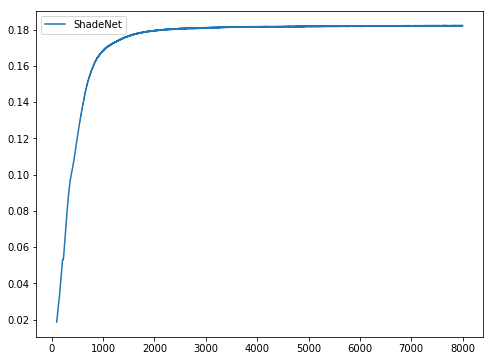

In [16]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(regret_net_report[['revenue']].rolling(100).mean(), label='ShadeNet');
ax.legend();

### What if the auctioneer can observe the common component?

Let's modify RegretNet to accept additional signals.

In [17]:
class RegretWithSignalsNetAllocation(nn.Module):
    def __init__(self, bidders, signal_count, hidden_layers, hidden_units):
        super(RegretWithSignalsNetAllocation, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders+signal_count, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders+1))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x, signals):
        x = torch.cat((x,signals), dim=1)
        for layer in self.fc_layers[:-1]:
            x = F.leaky_relu(layer(x))
        return F.softmax(self.fc_layers[-1](x), dim=1)

class RegretWithSignalsNetPayment(nn.Module):
    def __init__(self, bidders, signal_count, hidden_layers, hidden_units):
        super(RegretWithSignalsNetPayment, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders+signal_count, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x, signals):
        x = torch.cat((x,signals), dim=1)
        for layer in self.fc_layers:
            x = F.leaky_relu(layer(x))
        return x
    
class MechanismWithSignalsNet(nn.Module):
    def __init__(self, allocation_rule, payment_rule):
        super(MechanismWithSignalsNet, self).__init__()
        self.allocation_rule = allocation_rule
        self.payment_rule = payment_rule
        
    def forward(self, x, signals):
        allocation = self.allocation_rule(x, signals)
        return allocation, allocation[:,1:] * self.payment_rule(x, signals)

def calc_utility_with_signals(bids, signals, mechanism, valuation=None, output_components=False):
    valuation = valuation if valuation is not None else bids
    allocation, payment = mechanism(bids, signals)
    if output_components:
        return allocation[:,1:]*valuation-payment, allocation, payment
    else:
        return allocation[:,1:]*valuation-payment
    
def calc_regret_with_signals(values, signals, mechanism, responders, leaky=False):
    u_true, a_true, p_true = calc_utility_with_signals(values, signals, mechanism, output_components=True)
    regret = torch.zeros(values.shape).to(device)
    for bidder, responder in enumerate(responders):
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,bidder] = 1.0
        response = responder(values, a_true, p_true)
        u_response = calc_utility_with_signals(response, signals, mechanism, values)
        if leaky:
            regret = regret + F.leaky_relu((u_response - u_true) * bidder_mask)
        else:
            regret = regret + F.relu((u_response - u_true) * bidder_mask)
    return regret.mean(dim=0)

def train_with_signals(mechanism, responders, values_and_signals_loader, epochs=1, rho=100, clipping_norm=None):
    # Initialize augmented lagrangian parameters
    lambda_dsic = torch.zeros(bidders).to(device)
    lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-4)
    responder_optimizers = [optim.Adam(r.parameters(), lr=1e-4) for r in responders]
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_and_signals_loader):
            values = values_list[0].to(device)
            signals = values_list[1].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility_with_signals(
                values, signals, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = calc_regret_with_signals(
                values,
                signals,
                mechanism,
                responders)
    
            # compute individual rationality violation
            ir_violation = F.relu(-utility).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue\
                +(lambda_dsic*dsic_violation).sum()\
                +(lambda_ir*ir_violation).sum()\
                +0.5*rho*(total_dsic_violation.pow(2)+total_ir_violation.pow(2))
    
            # Trigger the autogradient calculation
            loss.backward()
        
            # Take a step towards the gradient
            mechanism_optimizer.step()
            
            with torch.no_grad():
                mechanism.eval()
                for responder in responders:
                    responder.eval()
                    
                # Update the augmented lagrangian parameters
                dsic_violation_next = calc_regret_with_signals(
                    values,
                    signals,
                    mechanism,
                    responders)
                u_next = calc_utility_with_signals(values, signals, mechanism)
                ir_violation_next = F.relu(-u_next).mean(dim=0)
                lambda_dsic = lambda_dsic + rho * dsic_violation_next
                lambda_ir = lambda_ir + rho * ir_violation_next
                mechanism.train()
                for responder in responders:
                    responder.train()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item(),
                'loss':loss.item()})
            
            for bidder, responder in enumerate(responders):
                optimizer = responder_optimizers[bidder]
                optimizer.zero_grad()
                regret = calc_regret_with_signals(
                    values,
                    signals,
                    mechanism,
                    responders,
                    leaky=True)
                (-regret[bidder]).backward()
                optimizer.step()
            
    return pd.DataFrame(report_data)     

def create_regret_net_with_signals(bidders, signal_count, hidden_layers=2, hidden_units=100):
    return MechanismWithSignalsNet(
        RegretWithSignalsNetAllocation(bidders, signal_count, hidden_layers, hidden_units),
        RegretWithSignalsNetPayment(bidders, signal_count, hidden_layers, hidden_units))

Again, the networks will train on data that is sampled from the value distribution and now the signals.

In [18]:
values_and_signals_loader=data_utils.DataLoader(
    data_utils.TensorDataset(values, common_components),
    batch_size=batch_size)

Load the new network that accepts signals.

In [19]:
regret_net_with_signals = create_regret_net_with_signals(bidders, 1).to(device)
regret_net_with_signals_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]

As above, we loop over the data for a number of epochs and record traces of the networks learning.

In [20]:
regret_net_with_signals_report = train_with_signals(regret_net_with_signals, regret_net_with_signals_responders, values_and_signals_loader, epochs=epochs)

100%|██████████| 1000/1000 [05:18<00:00,  1.93it/s]


RegretWithSignalsNet quickly settles into low DCIS violation.

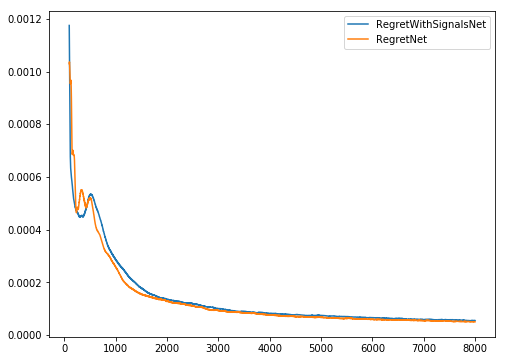

In [21]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(regret_net_with_signals_report[['total_dsic_violation']].rolling(100).mean(), label='RegretWithSignalsNet');
ax.plot(regret_net_report[['total_dsic_violation']].rolling(100).mean(), label='RegretNet');
ax.legend();

As we can see, and not surprisingly, having access to the additional signals improves revenue.

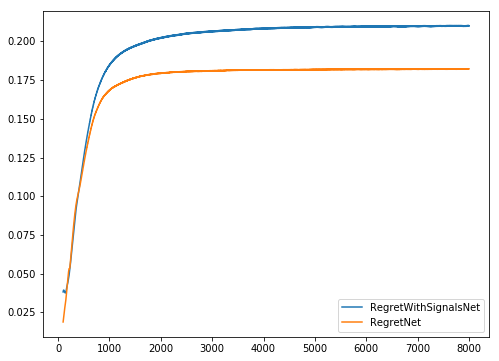

In [22]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(regret_net_with_signals_report[['revenue']].rolling(100).mean(), label='RegretWithSignalsNet');
ax.plot(regret_net_report[['revenue']].rolling(100).mean(), label='RegretNet');
ax.legend();